# 读取CSV文件

In [2]:
import pandas as pd
import jieba
import numpy as np

In [3]:
content=pd.read_csv(r'/Users/yang/Downloads/datasource-master/sqlResult_1558435.csv',encoding='gb18030')
content.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [4]:
content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89611 entries, 0 to 89610
Data columns (total 7 columns):
id         89611 non-null int64
author     79396 non-null object
source     89609 non-null object
content    87054 non-null object
feature    89611 non-null object
title      89577 non-null object
url        87144 non-null object
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


# 数据预处理

In [5]:
corpus=[' '.join(list(jieba.cut(str(content.iloc[i].content)))) for i in range(60000)]

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/kl/7_vv7v_15wnf5q65wh8tl5jh0000gn/T/jieba.cache
Loading model cost 1.194 seconds.
Prefix dict has been built succesfully.


In [6]:
source=[content.iloc[i].source for i in range(60000)]

In [7]:
target=[1 if i=='新华社' or i=='新华网' else 0 for i in source]

In [8]:
y=np.array(target)

In [9]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [56]:
from collections import Counter

Counter(y)

Counter({0: 10778, 1: 49222})

#### sklearn.feature_extraction.text  之 CountVectorizer用法 示例

from sklearn.feature_extraction.text import CountVectorizer
corpus1 = [
...     'This is the first document.',
...     'This document is the second document.',
...     'Is this the first document?',]
vectorizer = CountVectorizer()
X1 = vectorizer.fit_transform(corpus1)
print(vectorizer.get_feature_names())
print(X1.toarray())  

# 计算每个词的TF-IDF

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
vectorizer=CountVectorizer()

In [12]:
X=vectorizer.fit_transform(corpus)

In [13]:
np.shape(X)

(60000, 213294)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

In [15]:
transformer=TfidfTransformer()

In [16]:
tfidf=transformer.fit_transform(X)

In [17]:
tfidf.toarray

<bound method _cs_matrix.toarray of <60000x213294 sparse matrix of type '<class 'numpy.float64'>'
	with 5485430 stored elements in Compressed Sparse Row format>>

# 数据集拆分

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(tfidf, y, test_size=0.2, random_state=42)

# 决策树分类器

In [159]:
from sklearn import tree
clf=tree.DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=25, 
                                min_samples_split=2,min_samples_leaf =1, min_weight_fraction_leaf=0.0, 
                                max_features=None, random_state=42, max_leaf_nodes=None,class_weight=None, presort=False
)
clf=clf.fit(Xtrain, ytrain)
pred=clf.predict(Xtest)

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(pred, ytest, average='macro')  

(0.9847828348582978, 0.9782324962057907, 0.9814688075809422, None)

### 决策树可视化

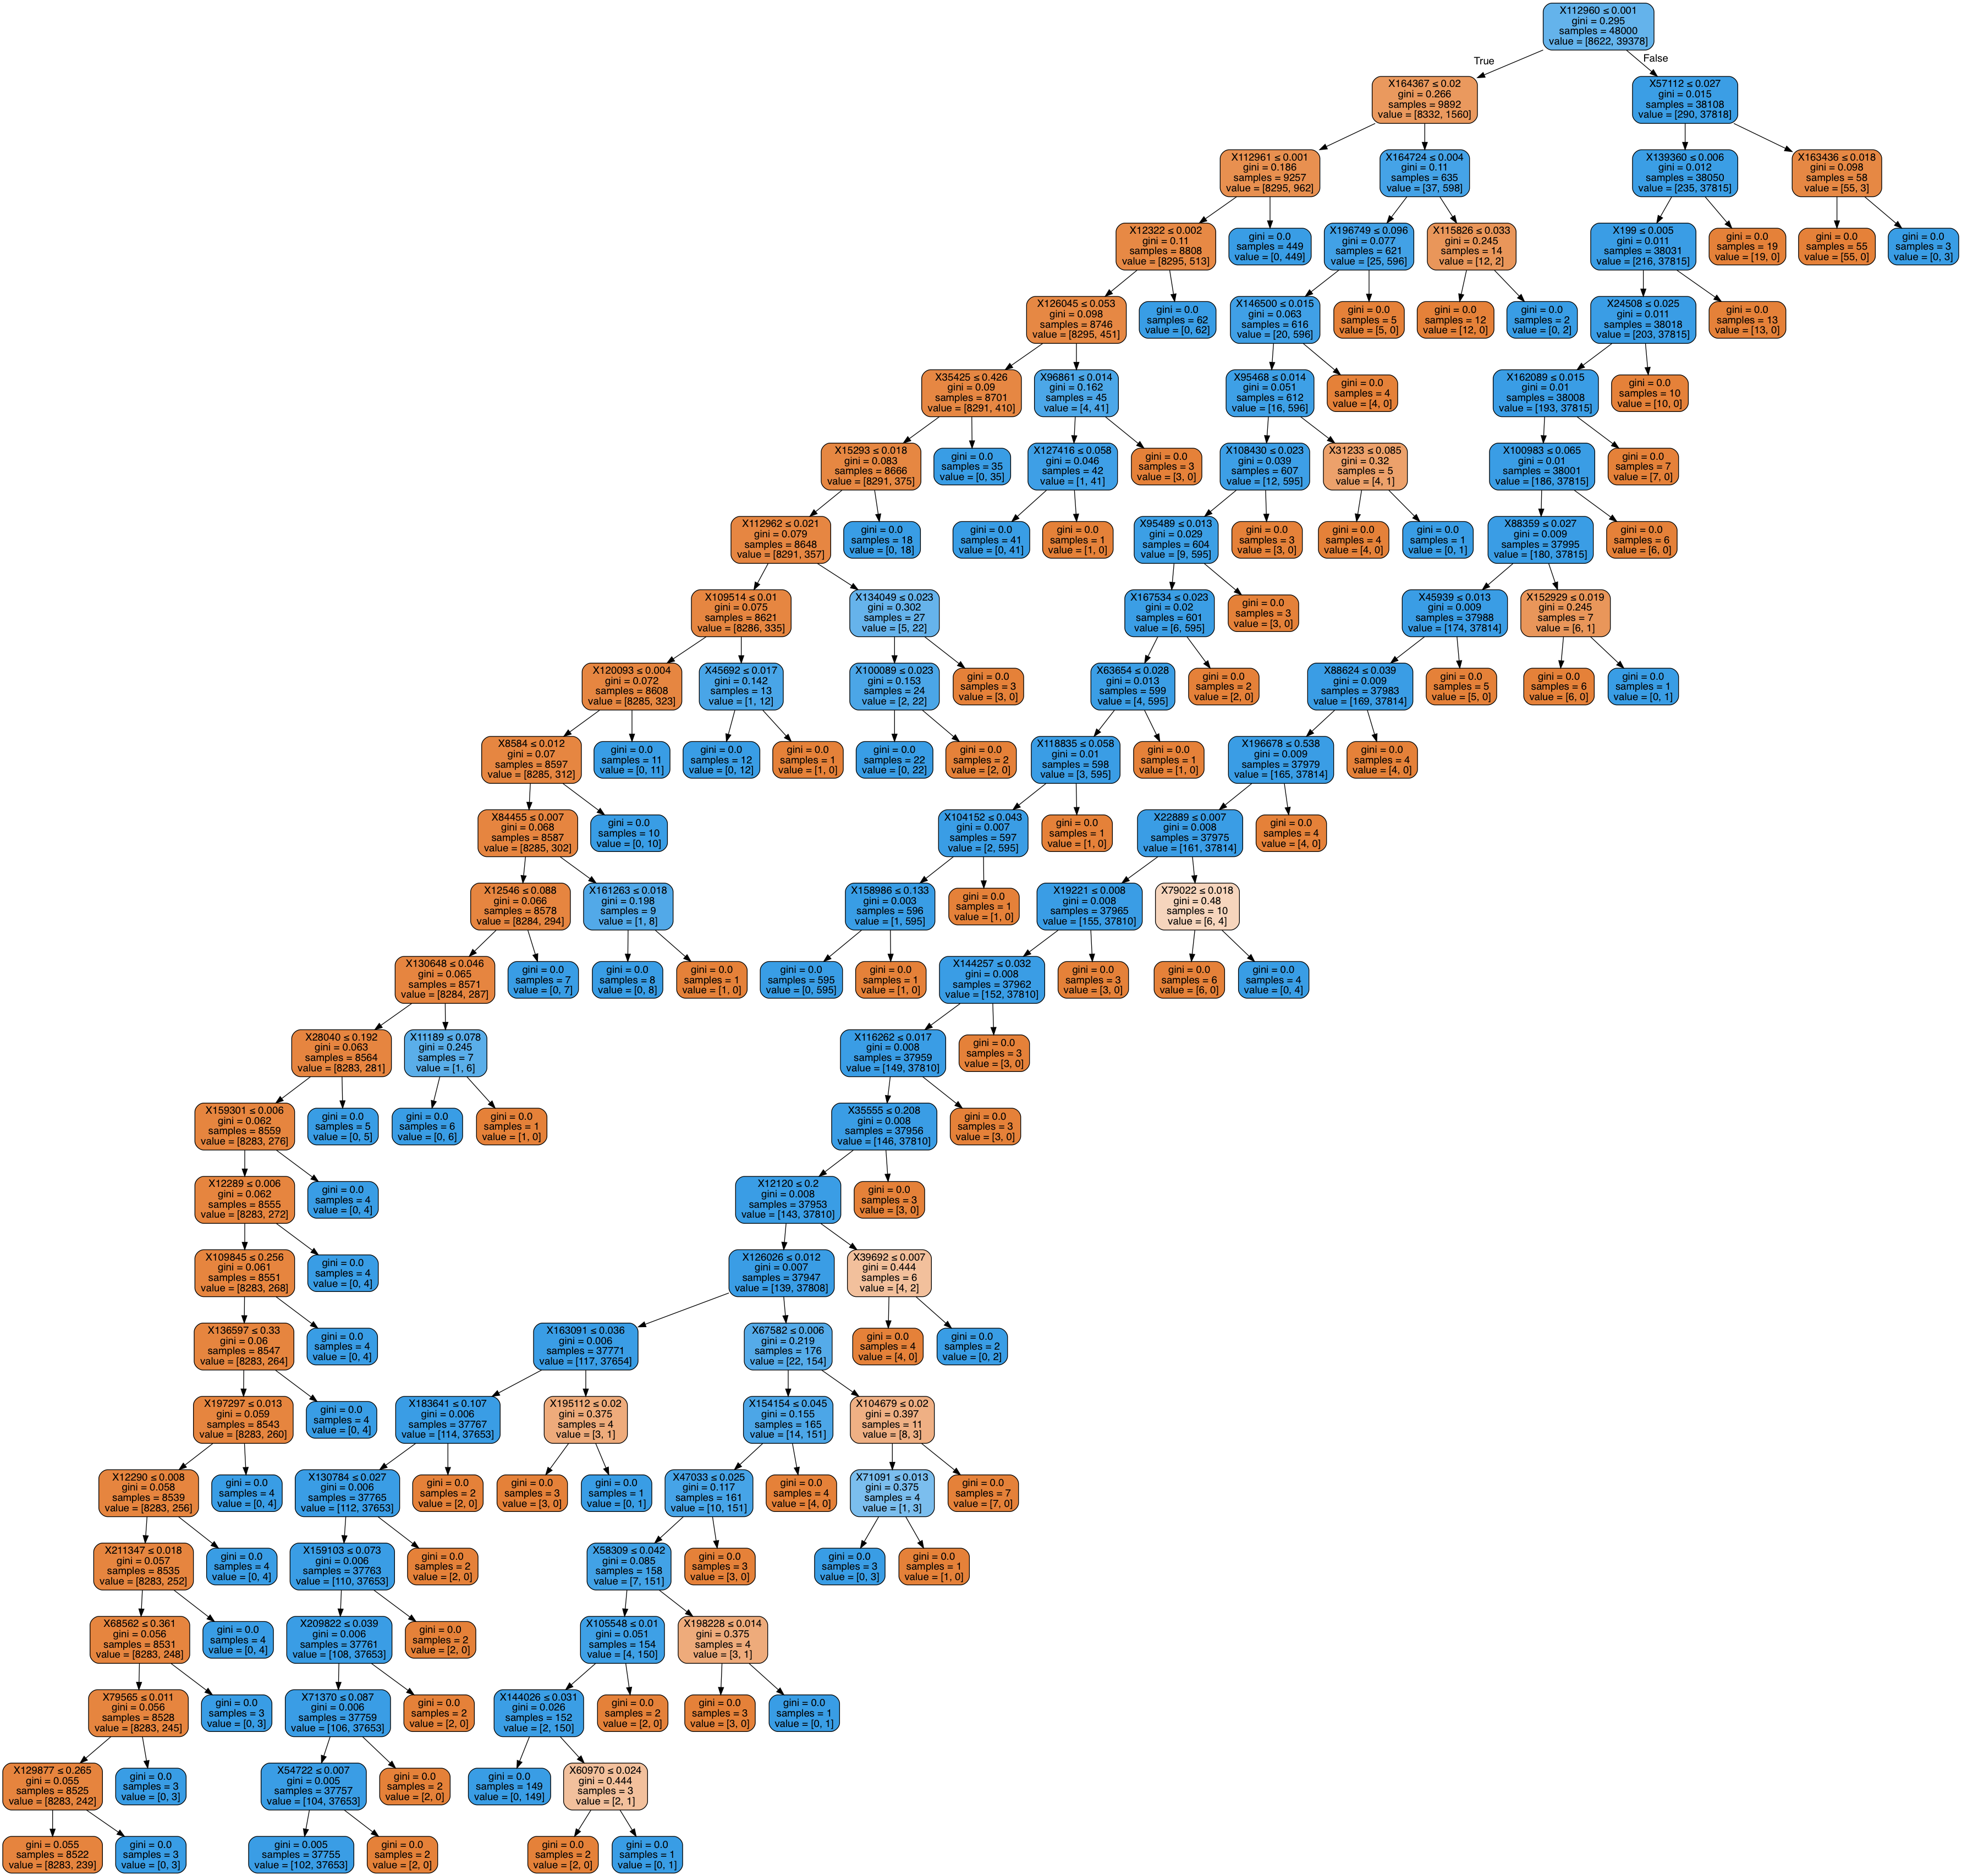

In [160]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

###### 决策树手动参数调优过程：

（1）：所有参数都是用默认值，得到的precision_recall_fscore值为(0.9771317525569572, 0.983108055887864, 0.9800878778840754），最大深度超过100，训练时间较长。

（2）：max_depth=5，得到的precision_recall_fscore值为（0.9821436110183426, 0.9734549811825217, 0.9777301128010638），且训练所用时间减少2/3

（3）：max_depth=10，得到的precision_recall_fscore值为(0.9831086658740922, 0.9775956166049705, 0.9803245659599251），用时几秒。

（4）：max_depth=20，得到的precision_recall_fscore值为(0.9845796654149821, 0.9773568522069087, 0.9809209129287048），用时十几秒

（5）：max_depth=25，得到的precision_recall_fscore值为(0.9847828348582978, 0.9782324962057907, 0.9814688075809422,）

（6）：max_depth=30，得到的precision_recall_fscore值为(0.9836520216301954, 0.9771169624163651, 0.9803457050100903）

# 随机梯度下降分类器

### 交叉验证

自动将X,y分成三部分（训练集，验证集和测试集），将任意之一作为测试集，其余部分最为训练集和验证集，
进行交叉验证，输出3个预测结果。

In [157]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42)  

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X, y, cv=3, scoring="f1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([0.97977734, 0.98100362, 0.98758713])

# 多项式朴素贝叶斯分类器

In [175]:
from sklearn.naive_bayes import MultinomialNB
mulNB_clf = MultinomialNB()
mulNB_clf.fit(Xtrain, ytrain)
NB_pre=mulNB_clf.predict(Xtest)

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(NB_pre,ytest, average='macro')

(0.7006671421108062, 0.9325063745277243, 0.7545574854037933, None)